In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## DATA LOADING

In [2]:
SPANS = pd.read_csv('data/traces.csv')
RESOURCES = pd.read_csv('data/resources.csv')

## Preprocessing

In [3]:
# DROP UNNECESSARY COLUMNS
SPANS = SPANS.drop([
    '_id', '__v', 'metadata.scope',
    'name', 'metadata.schema_url'
    ], axis=1)

# RENAME COLUMNS
SPANS = SPANS.rename(columns= {
    'attributes.source.net.host.ip': 'source_ip',
    'attributes.source.net.host.port': 'source_port',
    'attributes.target.net.peer.ip': 'target_ip',
    'attributes.target.net.peer.port': 'target_port',
    'attributes.operation.http.url': 'request_url',
    'attributes.operation.http.method': 'request_method',
    'attributes.operation.http.request_content_length_uncompressed': 'request_content_length',
    'attributes.operation.http.status_code': 'response_status_code',
    'attributes.operation.http.status_text': 'response_status_text',
    'attributes.operation.http.response_content_length_uncompressed': 'response_content_length',
    'attributes.operation.http.user_agent': 'user_agent',
    'attributes.operation.http.host': 'http_host',
    'metadata.resource_id': 'resource_id',
})

# PARSE COLUMN VALUES
SPANS['start_time'] = pd.to_datetime(SPANS['start_time'])
SPANS['end_time'] = pd.to_datetime(SPANS['end_time'])
SPANS['duration'] = pd.to_timedelta(SPANS['end_time'] - SPANS['start_time']).dt.total_seconds() * 1000
SPANS['request_content_length'] = pd.to_numeric(SPANS['request_content_length'])
SPANS['response_content_length'] = pd.to_numeric(SPANS['response_content_length'])

# MERGE COLUMN VALUES
SPANS['request'] = SPANS['request_method'] + ' ' + SPANS['request_url']
SPANS['response'] = SPANS['response_status_code'].astype(str) + ' ' + SPANS['response_status_text']

# DROP MERGED COLUMNS
SPANS = SPANS.drop(['request_method', 'request_url', 'response_status_code', 'response_status_text'], axis=1)

In [4]:
# DROP UNNECESSARY COLUMNS
RESOURCES = RESOURCES.drop([
    '__v', 'process.command', 'process.executable.name', 'process.executable.path', 'process.runtime.description'
], axis=1)

RESOURCES = RESOURCES.rename(columns= {
    'service.name': 'service_name',
    'service.version': 'service_version',
    'service.ip_addr': 'service_ip',
    'process.pid': 'pid',
    'process.owner': 'owner',
    'telemetry.sdk.language': 'telemetry_language',
    'telemetry.sdk.name': 'telemetry_name',
    'telemetry.sdk.version': 'telemetry_version',
    'process.runtime.name': 'runtime_name',
    'process.runtime.version': 'runtime_version',
})

# MERGE COLUMN VALUES
RESOURCES['command'] = RESOURCES['process.command_args.0'] + " " + RESOURCES['process.command_args.1'] + " " + RESOURCES['process.command_args.2'] + " " + RESOURCES['process.command_args.3']
RESOURCES['telemetry_sdk'] = RESOURCES['telemetry_language'] + "/" + RESOURCES['telemetry_name'] + ":" + RESOURCES['telemetry_version']
RESOURCES['runtime'] = RESOURCES['runtime_name'] + ":" + RESOURCES['runtime_version']

# DROP MERGED COLUMNS
RESOURCES = RESOURCES.drop([
    'telemetry_language', 'telemetry_name', 'telemetry_version',
    'runtime_name', 'runtime_version', 'process.command_args.0',
    'process.command_args.1', 'process.command_args.2', 'process.command_args.3'
], axis=1)

## Exploratory Data Analysis

In [5]:
TRACES = SPANS['trace_id'].unique() # Get traces ids

In [6]:
# SORT SPANS INSIDE A TRACE FOLLOWING THE PARENT-CHILD RELATIONSHIP IN DFS ORDER
def trace_dfs_sort_recursive(trace, parent, acc):
    if len(acc) == len(trace):
        return acc
    else:
        children = trace.loc[trace['parent_span_id'] == parent['span_id']].sort_values(by=['start_time'])
        for i, child in children.iterrows():
            acc = acc.append(child)
            acc = trace_dfs_sort_recursive(trace, child, acc)
        return acc

def trace_dfs_sort(trace_id):
    trace = SPANS.loc[SPANS['trace_id'] == trace_id]
    processed = pd.DataFrame(columns=trace.columns)
    parent = trace.loc[pd.isna(trace['parent_span_id'])].iloc[0]
    processed = processed.append(parent)
    children = trace.loc[trace['parent_span_id'] == parent['span_id']].sort_values(by=['start_time'])
    for i, child in children.iterrows():
        processed = processed.append(child)
        processed = trace_dfs_sort_recursive(trace, child, processed)
    return processed.reset_index(drop=True)

# GET THE HOST BASED ON IP
def get_host(span, scope):
    # When no source is declared, it is a request. Thus, thesource is the resource
    if scope == 'source' and pd.isna(span['source_ip']):
        return RESOURCES.loc[RESOURCES['_id'] == span['resource_id']]['service_name'].iloc[0]
    
    # When source does exist, it is a response. Thus, source must match http host
    elif scope == 'source' and not pd.isna(span['source_ip']): 
        return span['http_host']
        
    # When source does exist, it is a response. Thus, we look in resources for the target ip
    elif scope == 'target' and not pd.isna(span['source_ip']):
        host_name = RESOURCES.loc[RESOURCES['service_ip'] == span['target_ip'].replace("::ffff:", '')]['service_name']
        if len(host_name) > 0:
            return host_name.iloc[0]
        else:
            return 'external/uninstrumented'
    
    # On requests, the target is always the http host
    else:
        return span['http_host']

In [9]:
import plotly.express as px

def draw_trace(trace_id):
    # Get DFS SORTED TRACE
    TRACE = trace_dfs_sort(trace_id)    

    # ADD SOURCE AND TARGET COLUMNS FOR EXTRA INFORMATION
    TRACE['source'] = TRACE.apply(lambda x: f"{get_host(x, 'source')}({x['source_ip'] + ':' + str(x['source_port']) if not pd.isna(x['source_ip']) else RESOURCES.loc[RESOURCES['_id'] == x['resource_id']]['service_ip'].iloc[0]})", axis=1)
    TRACE['target'] = TRACE.apply(lambda x: f"{get_host(x, 'target')}({x['target_ip']}:{x['target_port']})", axis=1)

    # PLOT TRACE
    fig = px.timeline(TRACE, x_start="start_time", x_end="end_time",
        y="span_id", hover_data={"span_id": False, "duration": False, "source": True, "target": True, "response": True},
        text="duration", hover_name="request", title="Trace: " + TRACES[0],
    )
    fig.update_yaxes(showticklabels=False, autorange="reversed")
    fig.show()

In [10]:
draw_trace(TRACES[0])

In [12]:
# Draw a network graph of the trace based on source and target
import networkx as nx

def get_network_graph(trace_id):
    # Get DFS SORTED TRACE
    TRACE = trace_dfs_sort(trace_id)    

    # ADD SOURCE AND TARGET COLUMNS FOR EXTRA INFORMATION
    TRACE['source'] = TRACE.apply(lambda x: x['source_ip'].replace("::ffff:",'') if not pd.isna(x['source_ip']) else RESOURCES.loc[RESOURCES['_id'] == x['resource_id']]['service_ip'].iloc[0], axis=1)
    TRACE['target'] = TRACE.apply(lambda x: x['target_ip'].replace("::ffff:",''), axis=1)

    # BUILD GRAPH
    G = nx.DiGraph()
    for i, row in TRACE.iterrows():
        if pd.isna(row['source_ip']) or pd.isna(row['parent_span_id']):
            if G.has_edge(row['source'], row['target']):
                G[row['source']][row['target']]['weight'] += 1
            else:
                G.add_edge(row['source'], row['target'], weight=1)
    
    for edge in G.edges(data=True):
        G[edge[0]][edge[1]]['weight'] = G[edge[0]][edge[1]]['weight'] // (G.in_degree(edge[0]) if G.in_degree(edge[0]) > 0 else 1)
    
    G.graph['name'] = TRACE['request'].iloc[0]

    return G

def draw_network(G):
    # DRAW GRAPH
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=46)
    nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=1500, width=2)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    node_labels = map(lambda x: f"{RESOURCES[RESOURCES['service_ip'] == x]['service_name'].iloc[0] if len(RESOURCES[RESOURCES['service_ip'] == x]['service_name']) > 0 else 'external/uninstrumented'}\n({x})", list(nx.nodes(G)))
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    nx.draw_networkx_labels(G, pos, labels=dict(zip(list(nx.nodes(G)), node_labels)), font_size=8)
    ax = plt.gca()
    ax.margins(0.20)

    plt.title("Topology for " + G.graph['name'] )
    plt.show()


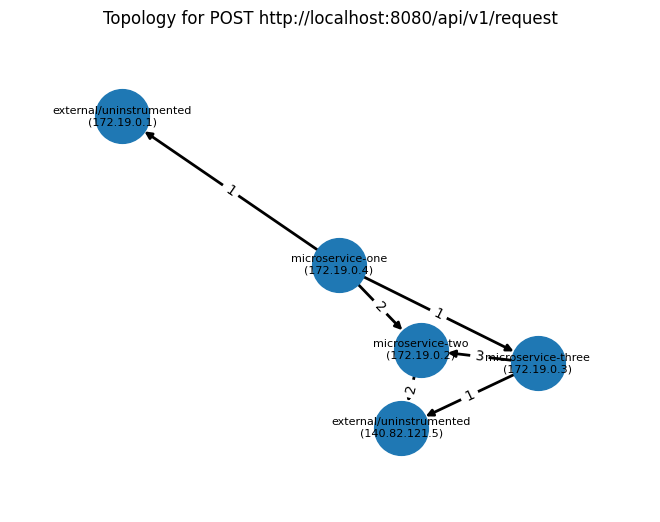

In [13]:
draw_network(get_network_graph(TRACES[0]))

## CAPACITY ANALYSIS

In [14]:
# We will use an API to send the model and obtain the result. 
# We need the requests and json libraries to send and parse requests and responses.

import requests, json 

# Some auxiliary constants and variables
TRACE = TRACES[0]
G = get_network_graph(TRACE)

SECONDS_PER_MONTH= 60*60*24*30
SECONDS_PER_DAY= 60*60*24
MAXIMUM_COST= 99999999.99

serviceName = 'test_infrastructure-' + G.graph['name'].replace(' ', '_').replace('/', '_').replace(':', '_').replace('.', '_').replace('?', '_').replace('&', '_').replace('=', '_').replace('-', '_')

api_url = 'https://smart-lama.services.governify.io/api/v2/lamas'
urlBase= api_url+'/'+serviceName+'/operations/'

In [15]:
# LAMA CRUD wrappers 

def post_lama(ldl):
    headers = {'Content-Type': 'application/json'}
    json_response = requests.post(api_url, data=json.dumps(ldl), headers=headers)
    res = json_response.status_code
    return res

def put_lama(ldl):
    headers = {'Content-Type': 'application/json'}
    json_response = requests.put(api_url+'/'+serviceName, data=json.dumps(ldl), headers=headers)
    res = json_response.status_code
    return res

def delete_lama():
    json_response = requests.delete(api_url+'/'+serviceName)
    res = json_response.status_code
    return res

In [16]:
# Operation wrappers

def maxRequests(timeWindow,maximumCost=MAXIMUM_COST,useOvg="false"):
    api_q= urlBase+'maxRequests?OpEx={0}&time={1}&useOvg={2}'.format(maximumCost,timeWindow,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def maxRequestsKeys(timeWindow,keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,useOvg="false"):
    api_q= urlBase+'maxRequests?K-E1-Basic={0}&K-E1-Premium={1}&K-E2-Silver={2}&K-E2-Gold={3}&time={4}&useOvg={5}'.format(keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,timeWindow,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def minCost(numRequests,numSeconds=SECONDS_PER_MONTH,useOvg="false"):
    api_q= urlBase+'minCost?reqL={0}&time={1}&useOvg={2}'.format(numRequests,numSeconds,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def minTime(numRequests,maximumCost=MAXIMUM_COST,useOvg="false"):
    api_q= urlBase+'minTime?reqL={0}&OpEx={1}&useOvg={2}'.format(numRequests, maximumCost,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def minTimeKeys(numRequests,keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,useOvg="false"):
    api_q= urlBase+'minTime?reqL={0}&K-E1-Basic={1}&K-E1-Premium={2}&K-E2-Silver={3}&K-E2-Gold={4}&useOvg={5}'.format(numRequests,keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)


### LAMA Creation

In [20]:
import ipaddress

# Adapt the information in the graph to the LAMA model
nodes = G.nodes()

# Get the entry point
entry = SPANS.loc[SPANS['trace_id'] == TRACE]
entry = entry.loc[pd.isna(entry['parent_span_id'])].sort_values(by=['start_time']).iloc[0]
entry = entry['target_ip'].replace("::ffff:",'').replace(".", "_")

# Infer the network id from the entry point target ip
network_id = ipaddress.ip_network(entry.replace("_", ".") + '/' + str(32 - len(nodes)), strict=False)

# Get internal and external services
internal_services = list(map(lambda x: x.replace(".", "_"), list(filter(lambda x: ipaddress.ip_address(x) in network_id, nodes))))
external_services = list(map(lambda x: x.replace(".", "_"), list(filter(lambda x: ipaddress.ip_address(x) not in network_id, nodes))))

# Map edges to the LAMA model (The entrypoint edge must be reversed since it is a response)
edges = map(lambda x: { "from": x[0].replace(".", "_"), "to": x[1].replace(".", "_"), "value": G[x[0]][x[1]]['weight'] }, G.edges(data=True))
relationships = list(map(lambda x: { "from": x['to'], "to": x['from'], "value": x['value'] } if x['from'] == entry else x, edges))

# Print the information
print("Internal services: ", internal_services)
print("External services: ", external_services)
print("Entry: ", entry)
print("Relationships: ", relationships)

Internal services:  ['172_19_0_4', '172_19_0_1', '172_19_0_2', '172_19_0_3']
External services:  ['140_82_121_5']
Entry:  172_19_0_1
Relationships:  [{'from': '172_19_0_4', 'to': '172_19_0_1', 'value': 1}, {'from': '172_19_0_4', 'to': '172_19_0_2', 'value': 2}, {'from': '172_19_0_4', 'to': '172_19_0_3', 'value': 1}, {'from': '172_19_0_2', 'to': '140_82_121_5', 'value': 2}, {'from': '172_19_0_3', 'to': '140_82_121_5', 'value': 1}, {'from': '172_19_0_3', 'to': '172_19_0_2', 'value': 3}]


In [21]:
# Description of the LAMA to analyse
lama_dl = {
    "id": serviceName,
    "services": internal_services,
    "external": external_services,
    "entry": entry,
    "relationships": relationships,
    "pricings": [
        {
            "external": external_services[0],
            "plans": [
                {
                    "name": "Authenticated",
                    "cost": 0.0,
                    "rate": 5000,
                    "rateunit": 86400,
                    "quota": 5000,
                    "quotaunit": 86400,
                    "ovg": 0.0
                }
            ]
        }
    ]
}

In [22]:
status = post_lama(lama_dl)
if status == 201:
    print('The LAMA for ' + serviceName + ' is succesfully created')
elif status == 409:
   # update/put the resource
    status_2 = put_lama(lama_dl)
    if status_2 == 204:
        print('The LAMA for ' + serviceName + ' was successfully updated')
    else:
        print('There was an error when updating the LAMA for ' + serviceName)
    #print('The LAMA for ' + serviceName + ' is already created')
else:
    print('There was an error when creating the LAMA for ' + serviceName)

The LAMA for test_infrastructure-POST_http___localhost_8080_api_v1_request is succesfully created


In [23]:
# Q1. What is the maximum number of requests that can be made in 1 minute? 

(MR,fullResponse) = maxRequests(60)
print ('The maximum number of requests than can be made in 1 minute is {0} '.format(MR))
print (fullResponse)

The maximum number of requests than can be made in 1 minute is 4545 
<pre>req172_19_0_4 = 4545;
req172_19_0_1 = 4545;
req172_19_0_2 = 22725;
req172_19_0_3 = 4545;
req140_82_121_5 = 49995;
reqL = 4545;
time = 60;
OpEx = 0.0;
limReq140_82_121_5 = array1d(Plans140_82_121_5, [49995]);
ovgReq140_82_121_5 = array1d(Plans140_82_121_5, [0]);
keys140_82_121_5 = array1d(Plans140_82_121_5, [10]);
OpEx140_82_121_5 = -0.0;
aux = 0;
----------
</pre>


In [24]:
delete_lama()

204

## Limitations

* It is not possible to automatically obtain the plans from external APIs, they must be entered manually.
* If not all services are implemented, it is not possible to identify external services when the infrastructure is distributed over several servers with different network identifiers.